# FCCU Monitoring via Classical PCA


## Heat exchanger fouling scenario

In [20]:
# import packages 
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})

In [21]:
# fetch NOC training data
data_train = pd.read_csv('NOC_varyingFeedFlow_outputs.csv', header=None).values
data_train = data_train[:,1:] # first column gives sampling time

N = data_train.shape[0]
m = data_train.shape[1]

In [22]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#     Fit PCA model and generate monitoring charts for traning dataset
############################################################################### 

In [23]:
# mean_center and scale NOC data
scaler = StandardScaler()
scaler.fit(data_train)
scaler.scale_[[3,4,16]] = 1 # these columns have negligible variance

data_train_normal = scaler.transform(data_train)

In [24]:
# fit PCA model
pca = PCA()
score_train = pca.fit_transform(data_train_normal)

In [25]:
# decide # of PCs to retain and compute reduced data in PC space
explained_variance = 100*pca.explained_variance_ratio_ # in percentage
cum_explained_variance = np.cumsum(explained_variance) # cumulative % variance explained

n_comp = np.argmax(cum_explained_variance >= 95) + 1
score_train_reduced = score_train[:,0:n_comp]

print('Number of PCs cumulatively explaining atleast 95% variance: ', n_comp)

Number of PCs cumulatively explaining atleast 95% variance:  4


In [26]:
# reconstruct original data
V_matrix = pca.components_.T
P_matrix = V_matrix[:,0:n_comp] 

data_train_normal_reconstruct = np.dot(score_train_reduced, P_matrix.T)

In [27]:
# calculate T2 for training data
k = n_comp

lambda_k = np.diag(pca.explained_variance_[0:k]) # eigenvalue = explained variance
lambda_k_inv = np.linalg.inv(lambda_k)

T2_train = np.zeros((N,))

for i in range(N):
    T2_train[i] = np.dot(np.dot(score_train_reduced[i,:],lambda_k_inv),score_train_reduced[i,:].T)

In [28]:
#% calculate Q for training data
error_train = data_train_normal - data_train_normal_reconstruct
Q_train = np.sum(error_train*error_train, axis = 1)

In [29]:
# control limits
T2_CL = np.percentile(T2_train, 99)
Q_CL = np.percentile(Q_train, 99)

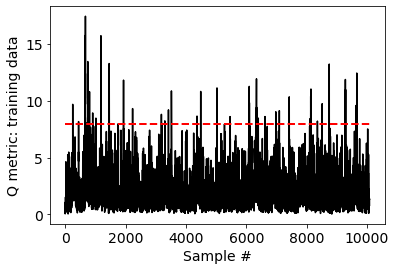

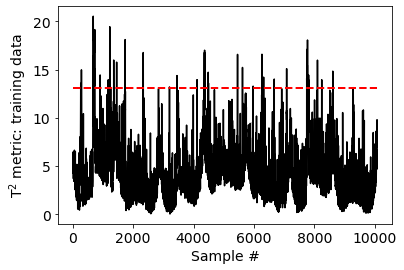

In [30]:
# Q_train plot with CL
plt.figure()
plt.plot(Q_train, color='black')
plt.plot([1,len(Q_train)],[Q_CL,Q_CL], linestyle='--',color='red', linewidth=2)
plt.xlabel('Sample #')
plt.ylabel('Q metric: training data')
plt.show()
           
# T2_train plot with CL
plt.figure()
plt.plot(T2_train, color='black')
plt.plot([1,len(T2_train)],[T2_CL,T2_CL], linestyle='--',color='red', linewidth=2)
plt.xlabel('Sample #')
plt.ylabel('T$^2$ metric: training data')
plt.show()

In [31]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#                       Faulty data analysis
############################################################################### 

In [32]:
# get test data, normalize it
data_test = pd.read_csv('UAf_decrease_outputs.csv', header=None).values
data_test = data_test[:,1:]

data_test_normal = scaler.transform(data_test) # using scaling parameters from training data

In [33]:
# compute scores and reconstruct
score_test = pca.transform(data_test_normal)
score_test_reduced = score_test[:,0:k]

data_test_normal_reconstruct = np.dot(score_test_reduced, P_matrix.T)

In [34]:
#calculate T2_test
T2_test = np.zeros((data_test_normal.shape[0],))

for i in range(data_test_normal.shape[0]): # eigenvalues from training data are used
    T2_test[i] = np.dot(np.dot(score_test_reduced[i,:],lambda_k_inv),score_test_reduced[i,:].T)

In [35]:
#calculate Q_test
error_test = data_test_normal_reconstruct - data_test_normal
Q_test = np.sum(error_test*error_test, axis = 1)

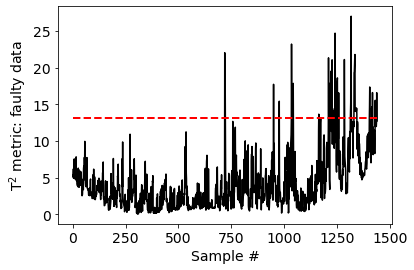

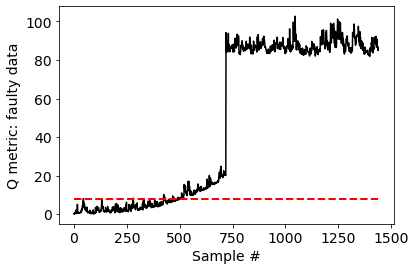

In [36]:
# plot T2_test and T2_train with CL
plt.figure(figsize=[6,4])
plt.plot(T2_test, color='black')
plt.plot([1,len(T2_test)],[T2_CL,T2_CL], linestyle='--',color='red', linewidth=2)
plt.xlabel('Sample #')
plt.ylabel('T$^2$ metric: faulty data')
plt.show()

# plot Q_test and Q_train with CL
plt.figure(figsize=[6,4])
plt.plot(Q_test, color='black')
plt.plot([1,len(Q_test)],[Q_CL,Q_CL], linestyle='--',color='red', linewidth=2)
plt.xlabel('Sample #')
plt.ylabel('Q metric: faulty data')
plt.show()

In [37]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                  fault diagnosis by contribution plots
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

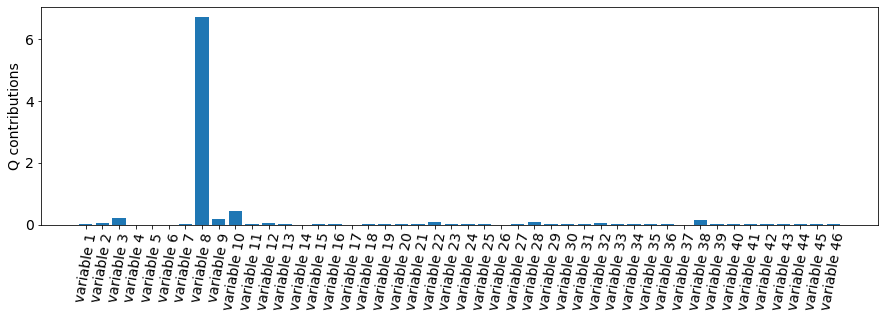

In [38]:
#%% Q contribution
sample = 500

error_test_sample = error_test[sample-1,]
Q_contri = error_test_sample*error_test_sample # vector of contributions

plt.figure(figsize=[15,4])
plt.bar(['variable ' + str((i+1)) for i in range(len(Q_contri))], Q_contri)
plt.xticks(rotation = 80)
plt.ylabel('Q contributions')
plt.show()

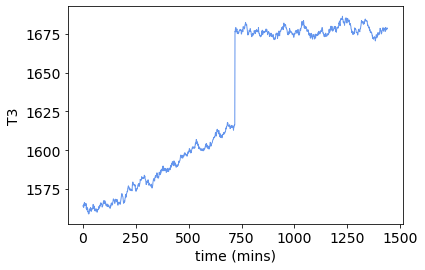

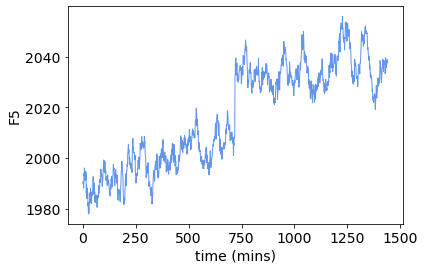

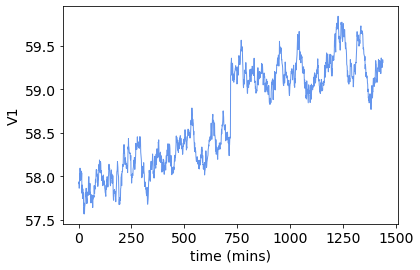

In [39]:
# plot top diagnosed variables
plt.figure(figsize=[6,4])
plt.plot(data_test[:,7],'cornflowerblue', linewidth=1)
plt.xlabel('time (mins)')
plt.ylabel('T3')

plt.figure(figsize=[6,4])
plt.plot(data_test[:,27],'cornflowerblue', linewidth=1)
plt.xlabel('time (mins)')
plt.ylabel('F5')

plt.figure(figsize=[6,4])
plt.plot(data_test[:,21],'cornflowerblue', linewidth=1)
plt.xlabel('time (mins)')
plt.ylabel('V1')
plt.show()